In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset
import gymnasium as gym

from astropy.io import fits
from datetime import datetime
import json
import fitsio
import pandas as pd
import time
import pickle

%reload_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('/home/hurra/Projects/survey-ops/')
from survey_ops.utils.units import *
from survey_ops.utils.geometry import *
from survey_ops.utils.interpolate import *
from survey_ops.utils.ephemerides import *
from survey_ops.src.environments import *
from survey_ops.src.offline_dataset import OfflineDECamDataset
from survey_ops.src.agents import Agent
from survey_ops.src.algorithms import DDQN, BehaviorCloning
from survey_ops.utils.pytorch_utils import seed_everything


IndentationError: expected an indented block after function definition on line 281 (offline_dataset.py, line 282)

In [5]:
seed_everything(10)

# Load and cut data from fits file, save as .json

In [6]:
data_json_fn = '../data/data.json'
data_fits_fn = '../data/decam-exposures-20251107.fits.gz'

try:
    # --- Load json df ---- #
    df = pd.read_json(data_json_fn)
    print('Loaded data from json')
except:
    # --- Load fits ---- #
    print(data_json_fn, 'DNE. Loading and processing data from fits.')
    d = fitsio.read('../data/decam-exposures-20251107.fits.gz')
    sel = (d['propid'] == '2012B-0001') & (d['exptime'] > 40) & (d['exptime'] < 100) & (~np.isnan(d['teff']))
    selected_d = d[sel]
    column_names = selected_d.dtype.names
    df = pd.DataFrame(selected_d, columns=column_names)
    print(df['datetime'].dtype)
    
    # mask = np.array([False if 'None' in dt else True for dt in subs_data['datetime']])
    # subs_data = {key: subs_data[key][mask] for key in subs_data.keys()}
    
    df.to_json(data_json_fn, indent=2)
    df = pd.read_json(data_json_fn)
    

Loaded data from json


In [8]:
import healpy as hp

In [14]:
hpGrid = HealpixGrid(nside=8)

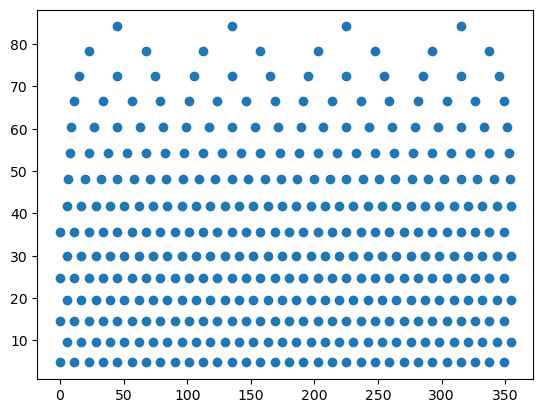

In [22]:
plt.scatter(hpGrid.lon/deg, hpGrid.lat/deg)

In [9]:
nside = 8
npix = hp.nside2npix(nside=nside)

In [10]:
x, y = hp.pix2ang(nside, np.arange(npix), lonlat=True)

# Instantiate the offline dataset choosing number of bins for (az,el)

In [49]:
import numpy as np
import torch
from torch.utils.data import DataLoader, RandomSampler
from collections import defaultdict

class OfflineDataset(torch.utils.data.Dataset):
    def __init__(self, 
                df: pd.DataFrame, 
                num_bins_1d = 10,
                normalize_state: bool = True, 
                specific_years: list = None,
                specific_months: list = None,
                specific_days: list = None,
                specific_filters: list = None
                ):
        self.state_vars = ['az', 'el', 'sun_az', 'sun_el', 'moon_az', 'moon_el', 'airmass', 'ha'] # time left in night
        self.normalize_state = normalize_state

        # Add timestamps column to df and sort df by timestamp (increasing)
        utc = pd.to_datetime(df['datetime'], utc=True)
        timestamps = (utc.astype('int64') // 10**9).values
        df['timestamp'] = timestamps
        df = df.sort_values(by='timestamp')

        # Ensure all data are 32-bit precision before training
        for str_bit, np_bit in zip(['float64', 'int64'], [np.float32, np.int32]): 
            cols = df.select_dtypes(include=[str_bit]).columns
            df[cols] = df[cols].astype(np_bit)
        
        # Set the DataFrame index as its datetime
        # df = df.set_index('datetime')
        # df.index = ((df.index) - pd.Timedelta(hours=np.max(np.unique(df.index.hour))))
        # df = df[df.index.year != 1970]
        df['night'] = (df['datetime'] - pd.Timedelta(hours=12)).dt.normalize()

        # Get observations for specific years, days, filters, etc.
        if specific_years is not None:
            df = df[df['night'].dt.year.isin(specific_years)]
        if specific_months is not None:
            df = df[df['night'].dt.month.isin(specific_months)]
        if specific_days is not None:
            df = df[df['night'].dt.day.isin(specific_days)]
        if specific_filters is not None:
            df = df[df['filter'].isin(specific_filters)]
        # remove observations in 1970 - what are these?
        df = df[df['night'].dt.year != 1970]
        self._df = df # save for diagnostics - #TODO remove when all is tested
        
        # Group observations by observation night
        groups = df.groupby('night')
        self._groups = groups
        self.unique_nights = groups.groups.keys()
        self.n_nights = groups.ngroups
        self.n_obs_per_night = groups.size() # nights have different numbers of observations
        
        # Set dataset-wide (across observation nights) attributes
        self.n_obs_tot = len(df)
        self.num_transitions = len(df) # size of dataset
        self.num_actions = int(num_bins_1d**2)
        
        # Get transition variables
        states, next_states = self._construct_states(groups)
        actions = self._construct_actions(next_states, num_bins_1d)
        rewards = self._construct_rewards(groups)
        dones = np.zeros(self.num_transitions, dtype=bool) # False unless last observation of the night
        self._done_indices = np.where(states[:, 0] == 0)[0][1:] - 1
        dones[self._done_indices] = True
        dones[-1] = True
        action_masks = self._construct_action_masks()

        # Save transitions as tensors and instatiate as attributes
        self.states = torch.tensor(states, dtype=torch.float32)
        self.next_states = torch.tensor(next_states, dtype=torch.float32)
        self.actions = torch.tensor(actions, dtype=torch.int32)
        self.rewards = torch.tensor(rewards, dtype=torch.float32)
        self.dones = torch.tensor(dones, dtype=torch.bool)
        self.action_masks = torch.tensor(action_masks, dtype=torch.bool)
        
        # Set dimension of observation
        self.obs_dim = self.states.shape[-1]
        if self.normalize_state:
            self.means = torch.mean(self.next_states, axis=0)
            self.stds = torch.std(self.next_states, axis=0)
            self.next_states = (self.next_states - self.means) / self.stds

            mask_null = self.states == 0
            new_states = self.states.clone()
            new_states = (new_states - self.means) / self.stds
            new_states[mask_null] = 0.
            self.states = new_states
        else:
            self.means = 0.
            self.stds = 1.

    def __len__(self):
        return self.states.shape[0]

    def __getitem__(self, idx):
        transition = (
            self.states[idx],
            self.actions[idx],
            self.rewards[idx],
            self.next_states[idx],
            self.dones[idx],
            self.action_masks[idx]
        )
        return transition

    def _construct_states(self, groups):
        """
        Constructs state and next_states for all transitions.
        Inserts a "null" observation before the first observation each night.
        The null observation state is defined as being an array of zeros
        """
        # State vars
        az = np.zeros(shape=(self.n_obs_tot + self.n_nights), dtype=np.float32) # need to add plus 1 for the null observation each night
        el = np.zeros_like(az, dtype=np.float32)
        sun_az = np.zeros_like(az, dtype=np.float32)
        sun_el = np.zeros_like(az, dtype=np.float32)
        moon_az = np.zeros_like(az, dtype=np.float32)
        moon_el = np.zeros_like(az, dtype=np.float32)
        airmass = np.zeros_like(az, dtype=np.float32)
        ha = np.zeros_like(az, dtype=np.float32)
        timestamp = np.zeros_like(az, dtype=np.int32)
        null_obs_indices = []

        # Extra info
        # ra = -1 * np.ones_like(az, dtype=np.float32)
        # dec = 
        
        for i, ((day, subdf), (_, idxs)) in enumerate(zip(groups, groups.indices.items())):
            indices = idxs + i + 1
            null_obs_indices.append(idxs[0] + i)
            timestamp[indices] = subdf['timestamp']
            az[indices] = subdf['az'].values
            el[indices] = 90.0 - subdf['zd'].values
            airmass[indices] = subdf['airmass'].values
            ha[indices] = subdf['ha'].values
            
            
            # Get sun and moon az,el
            for idx, time in zip(indices, timestamp):
                sun_ra, sun_dec = get_source_ra_dec('sun', time=time)
                moon_ra, moon_dec = get_source_ra_dec('moon', time=time)
                sun_az[idx], sun_el[idx] = equatorial_to_topographic(ra=sun_ra, dec=sun_dec, time=time)
                moon_az[idx], moon_el[idx] = equatorial_to_topographic(ra=moon_ra, dec=moon_dec, time=time)
                
        null_obs_indices = np.array(null_obs_indices, dtype=np.int32)
        self.null_mask = np.ones_like(az, dtype=bool)
        self.null_mask[null_obs_indices] = False
        print(self.null_mask.shape)
        all_states = np.vstack((az, el, sun_az, sun_el, moon_az, moon_el, airmass, ha)).T
        print(all_states.shape)
        self._all_states = all_states
        states = np.delete(all_states, null_obs_indices[1:] - 1, axis=0)[:-1]
        next_states = np.delete(all_states, null_obs_indices, axis=0)
        self.az, self.el, self.sun_az, self.sun_el, self.moon_az, self.moon_el, self.airmass, self.ha = next_states.T.copy()

        return states, next_states
    
    # def id2azel()

    def _construct_actions(self, next_states, num_bins_1d):
        az_edges = np.linspace(0, 360, num_bins_1d + 1, dtype=np.float32)
        # az_centers = az_edges[:-1] + (az_edges[1] - az_edges[0])/2
        el_edges = np.linspace(27, 90, num_bins_1d + 1, dtype=np.float32)
        # az_centers = el_edges[:-1] + (el_edges[1] - el_edges[0])/2

        i_x = np.digitize(next_states[:, 0], az_edges).astype(np.int32) - 1
        i_y = np.digitize(next_states[:, 1], el_edges).astype(np.int32) - 1
        bin_ids = i_x + i_y * (num_bins_1d)
        self.az_edges = az_edges
        self.el_edges = el_edges
        
        id2azel = defaultdict(list)
        for az, el, bin_id in zip(next_states[:, 0], next_states[:, 1], bin_ids):
            id2azel[bin_id].append((az, el))            
        self.id2azel = dict(sorted(id2azel.items()))

        id2radec = defaultdict(list)
        for ra, dec, bin_id in zip(self._df['ra'].values, self._df['dec'].values, bin_ids):
            id2radec[bin_id].append((ra, dec))
        self.id2radec = dict(sorted(id2radec.items()))
        return bin_ids

    def _construct_rewards(self, groups):
        rewards = np.ones(self.num_transitions)
        for ((day, subdf), (_, idxs)) in zip(groups, groups.indices.items()):
            rewards[idxs] = subdf['teff']
        return rewards

    def _construct_action_masks(self):
        return np.ones((self.num_transitions, self.num_actions), dtype=bool)

    def get_dataloader(self, batch_size, num_workers, pin_memory):
        loader = DataLoader(
            self,
            batch_size,
            sampler=RandomSampler(
                self,
                replacement=True,
                num_samples=10**10,
            ),
            drop_last=True, # drops last non-full batch
            num_workers=num_workers,
            pin_memory=pin_memory
        )
        return loader

In [50]:
num_bins_1d = 19
dataset = OfflineDataset(
    df, 
    num_bins_1d=19, 
    normalize_state=True,
    specific_years=[2013],
    specific_months=[8, 9],
    specific_days=[31, 1, 2],
    # specific_filters=['r', 'g']
)

(447,)
(447, 8)


In [51]:
dataset._df

,expnum,ra,dec,exptime,filter,propid,program,teff,fwhm,datetime,az,zd,ha,airmass,qc_fwhm,qc_cloud,qc_sky,qc_teff,timestamp,night
0,229250,301.199036,-50.938332,90,g,2012B-0001,survey,0.41,1.15,2013-08-31 23:55:07,139.550003,32.209999,-33.208458,1.18,1.15,0.42,1.26,0.41,1377993307,2013-08-31
1,229251,300.851105,-52.967278,90,g,2012B-0001,survey,0.60,1.18,2013-08-31 23:57:08,143.320007,32.759998,-32.380917,1.19,1.18,0.15,1.23,0.60,1377993428,2013-08-31
2,229252,300.460083,-54.996220,90,g,2012B-0001,survey,0.62,1.17,2013-08-31 23:59:08,146.949997,33.419998,-31.494499,1.20,1.17,-0.07,1.22,0.62,1377993548,2013-08-31
3,229253,300.016754,-57.024887,90,g,2012B-0001,survey,0.52,1.29,2013-09-01 00:01:11,150.449997,34.209999,-30.536041,1.21,1.29,-0.21,1.20,0.52,1377993671,2013-08-31
4,229254,302.722076,-58.040192,90,g,2012B-0001,survey,0.44,1.40,2013-09-01 00:03:13,150.589996,35.759998,-32.738377,1.23,1.40,0.04,1.20,0.44,1377993793,2013-08-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
439,230147,346.580597,-51.123997,90,i,2012B-0001,survey,0.96,1.00,2013-09-03 06:06:16,205.660004,24.170000,16.417084,1.10,1.00,-0.03,6.62,0.96,1378188376,2013-09-02
440,230148,352.174561,-53.153000,90,g,2012B-0001,survey,0.66,1.17,2013-09-03 06:08:36,196.779999,24.370001,11.475708,1.10,1.17,-0.07,1.14,0.66,1378188516,2013-09-02
441,230149,352.174530,-53.153027,90,r,2012B-0001,survey,0.69,1.11,2013-09-03 06:10:34,197.330002,24.469999,11.893500,1.10,1.11,-0.07,2.76,0.69,1378188634,2013-09-02
442,230194,9.097217,-40.979858,45,Y,2012B-0001,survey,0.35,1.40,2013-09-03 09:57:04,240.869995,42.860001,51.866333,1.36,1.40,0.07,15.51,0.35,1378202224,2013-09-02


# Configure model, data selection, and training setup

In [52]:
SEED = 10
seed_everything(SEED)
torch.set_default_dtype(torch.float32)
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "cpu"   
)

In [53]:
num_bins_1d = 19
dataset = OfflineDataset(
    df, 
    num_bins_1d=19, 
    normalize_state=True,
    specific_years=[2013],
    specific_months=[8, 9],
    specific_days=[31, 1, 2],
    # specific_filters=['r', 'g']
)

(447,)
(447, 8)


In [49]:
batch_size = 32
num_workers = 4
pin_memory = True if device == 'cuda' else False
trainloader = dataset.get_dataloader(batch_size, num_workers = num_workers, pin_memory = pin_memory)


In [53]:
"""Algorithm and Train setup"""

alg_config = {
    'obs_dim': dataset.obs_dim,
    'num_actions': dataset.num_actions,
    'hidden_dim': 64,
    'device': device,
    'lr': 3e-3,
    'loss_fxn': None, #torch.nn.cross_entropy,
    # 'use_double': True,
}
alg = BehaviorCloning(**alg_config)

fit_config = {
    'num_epochs' : 100,
    'batch_size': batch_size,
    # 'learning_start': 
    }

env_name = 'TelescopeEnv-v0'

def create_exp_name(alg, env_name, dataset, fit_config, alg_config):
    exp_name = f"{alg.name}"
    exp_name += f"-{env_name}"
    exp_name += f"-n_nights={dataset.n_nights}"
    # config_prefix += f"-use_double={alg_config['use_double']}"
    exp_name += f"-num_epochs={fit_config['num_epochs']}"
    exp_name += f"-batch_size={fit_config['batch_size']}"
    exp_name += f"-lr={alg_config['lr']}"
    return exp_name

exp_name = create_exp_name(alg, env_name, dataset, fit_config, alg_config)

outdir = f'../results/{exp_name}/'
if not os.path.exists(outdir):
    os.makedirs(outdir)
fig_outdir = outdir + 'figures/'
if not os.path.exists(fig_outdir):
    os.makedirs(fig_outdir)

agent_config = {
    'algorithm': alg,
    'normalize_obs': dataset.normalize_state,
    'outdir': outdir
    }

agent = Agent(**agent_config)



# Visualize dataset in (az, el) and binning sizes

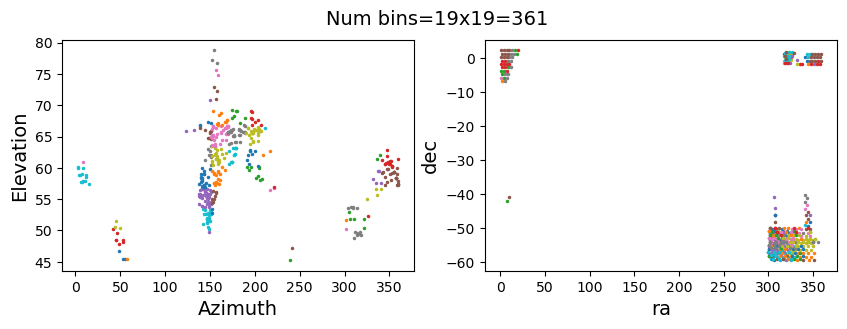

In [54]:
s = 1000/len(dataset)
fig, axs = plt.subplots(1,2, figsize=(10,3))
for bin_id in dataset.id2azel.keys():
    field_ids = np.array(dataset.id2azel[bin_id])
    axs[0].scatter(field_ids[:, 0], field_ids[:, 1], label='bin' + str(bin_id), s=s)
axs[0].set_xlabel('Azimuth', fontsize=14)
axs[0].set_ylabel('Elevation', fontsize=14)

for bin_id in dataset.id2radec.keys():
    field_ids = np.array(dataset.id2radec[bin_id])
    axs[1].scatter(field_ids[:, 0], field_ids[:, 1], label='bin' + str(bin_id), s=s)
axs[1].set_xlabel('ra', fontsize=14)
axs[1].set_ylabel('dec', fontsize=14)

fig.suptitle(f'Num bins={num_bins_1d}x{num_bins_1d}={dataset.num_actions}', fontsize=14)
fig.savefig(fig_outdir + 'plot_observations_in_sky_colored_bins.png')

# Train

In [55]:
start_time = time.time()
"""Train"""
agent.fit(
    dataloader=trainloader,
    **fit_config
    )
end_time = time.time()
train_time = end_time - start_time
print(f'Total train time = {train_time}s')

  0%|▏                                     | 153/44400 [00:00<00:53, 826.35it/s]

Train step 0: Accuracy = 0.062, Loss = 5.8406
Train step 100: Accuracy = 0.438, Loss = 2.6982
Train step 200: Accuracy = 0.500, Loss = 2.0204


  1%|▍                                    | 502/44400 [00:00<00:40, 1091.84it/s]

Train step 300: Accuracy = 0.438, Loss = 1.8204
Train step 400: Accuracy = 0.406, Loss = 1.6747
Train step 500: Accuracy = 0.406, Loss = 1.5236


  2%|▌                                    | 733/44400 [00:00<00:39, 1119.63it/s]

Train step 600: Accuracy = 0.562, Loss = 1.5777
Train step 700: Accuracy = 0.500, Loss = 1.2984
Train step 800: Accuracy = 0.531, Loss = 1.1768


  2%|▉                                   | 1089/44400 [00:01<00:37, 1162.32it/s]

Train step 900: Accuracy = 0.406, Loss = 1.3388
Train step 1000: Accuracy = 0.531, Loss = 1.2077
Train step 1100: Accuracy = 0.562, Loss = 1.5647


  3%|█                                   | 1322/44400 [00:01<00:37, 1142.77it/s]

Train step 1200: Accuracy = 0.500, Loss = 1.5603
Train step 1300: Accuracy = 0.531, Loss = 1.1912
Train step 1400: Accuracy = 0.406, Loss = 1.6380


  4%|█▎                                  | 1670/44400 [00:01<00:37, 1142.09it/s]

Train step 1500: Accuracy = 0.344, Loss = 1.5299
Train step 1600: Accuracy = 0.562, Loss = 1.3591
Train step 1700: Accuracy = 0.531, Loss = 1.1356


  5%|█▋                                  | 2012/44400 [00:01<00:37, 1120.30it/s]

Train step 1800: Accuracy = 0.531, Loss = 1.2370
Train step 1900: Accuracy = 0.500, Loss = 1.2055
Train step 2000: Accuracy = 0.375, Loss = 1.5059


  5%|█▊                                  | 2241/44400 [00:02<00:37, 1129.39it/s]

Train step 2100: Accuracy = 0.469, Loss = 1.3218
Train step 2200: Accuracy = 0.719, Loss = 1.2754
Train step 2300: Accuracy = 0.688, Loss = 1.1229


  6%|██                                  | 2582/44400 [00:02<00:37, 1114.73it/s]

Train step 2400: Accuracy = 0.594, Loss = 1.2945
Train step 2500: Accuracy = 0.406, Loss = 1.7880
Train step 2600: Accuracy = 0.625, Loss = 1.2896


  7%|██▎                                 | 2926/44400 [00:02<00:36, 1123.53it/s]

Train step 2700: Accuracy = 0.406, Loss = 1.2896
Train step 2800: Accuracy = 0.594, Loss = 1.4137
Train step 2900: Accuracy = 0.625, Loss = 1.2698


  7%|██▌                                 | 3158/44400 [00:02<00:36, 1139.74it/s]

Train step 3000: Accuracy = 0.531, Loss = 1.4895
Train step 3100: Accuracy = 0.625, Loss = 1.2909
Train step 3200: Accuracy = 0.625, Loss = 1.2657


  8%|██▊                                 | 3506/44400 [00:03<00:35, 1143.05it/s]

Train step 3300: Accuracy = 0.375, Loss = 1.2205
Train step 3400: Accuracy = 0.469, Loss = 1.3874
Train step 3500: Accuracy = 0.375, Loss = 1.4492


  8%|███                                 | 3740/44400 [00:03<00:35, 1146.15it/s]

Train step 3600: Accuracy = 0.531, Loss = 1.0808
Train step 3700: Accuracy = 0.469, Loss = 1.6246
Train step 3800: Accuracy = 0.625, Loss = 1.2674


  9%|███▎                                | 4090/44400 [00:03<00:34, 1156.53it/s]

Train step 3900: Accuracy = 0.531, Loss = 0.8637
Train step 4000: Accuracy = 0.500, Loss = 0.9907
Train step 4100: Accuracy = 0.500, Loss = 1.2094


 10%|███▌                                | 4321/44400 [00:03<00:35, 1138.77it/s]

Train step 4200: Accuracy = 0.531, Loss = 1.0881
Train step 4300: Accuracy = 0.656, Loss = 1.0514
Train step 4400: Accuracy = 0.562, Loss = 0.9867


 11%|███▊                                | 4674/44400 [00:04<00:34, 1158.15it/s]

Train step 4500: Accuracy = 0.594, Loss = 1.0659
Train step 4600: Accuracy = 0.406, Loss = 1.0088
Train step 4700: Accuracy = 0.594, Loss = 1.1865


 11%|████                                | 5022/44400 [00:04<00:34, 1136.10it/s]

Train step 4800: Accuracy = 0.562, Loss = 0.8983
Train step 4900: Accuracy = 0.562, Loss = 0.9815
Train step 5000: Accuracy = 0.625, Loss = 0.7563


 12%|████▎                               | 5250/44400 [00:04<00:34, 1129.94it/s]

Train step 5100: Accuracy = 0.688, Loss = 0.9824
Train step 5200: Accuracy = 0.531, Loss = 1.0210
Train step 5300: Accuracy = 0.594, Loss = 1.0841


 13%|████▌                               | 5602/44400 [00:04<00:33, 1142.67it/s]

Train step 5400: Accuracy = 0.500, Loss = 1.1781
Train step 5500: Accuracy = 0.688, Loss = 0.9705
Train step 5600: Accuracy = 0.562, Loss = 1.0143


 13%|████▋                               | 5835/44400 [00:05<00:33, 1151.62it/s]

Train step 5700: Accuracy = 0.594, Loss = 1.0131
Train step 5800: Accuracy = 0.312, Loss = 0.9236
Train step 5900: Accuracy = 0.656, Loss = 0.7873


 14%|█████                               | 6181/44400 [00:05<00:33, 1125.13it/s]

Train step 6000: Accuracy = 0.500, Loss = 0.9446
Train step 6100: Accuracy = 0.594, Loss = 1.0533
Train step 6200: Accuracy = 0.562, Loss = 1.0998


 15%|█████▎                              | 6530/44400 [00:05<00:32, 1149.51it/s]

Train step 6300: Accuracy = 0.594, Loss = 0.8335
Train step 6400: Accuracy = 0.406, Loss = 1.0111
Train step 6500: Accuracy = 0.594, Loss = 1.0355


 15%|█████▍                              | 6767/44400 [00:05<00:32, 1164.91it/s]

Train step 6600: Accuracy = 0.594, Loss = 0.7659
Train step 6700: Accuracy = 0.625, Loss = 1.0364
Train step 6800: Accuracy = 0.594, Loss = 1.4605


 16%|█████▊                              | 7117/44400 [00:06<00:32, 1151.10it/s]

Train step 6900: Accuracy = 0.469, Loss = 0.8337
Train step 7000: Accuracy = 0.594, Loss = 1.0711
Train step 7100: Accuracy = 0.531, Loss = 1.3978


 17%|█████▉                              | 7347/44400 [00:06<00:32, 1123.79it/s]

Train step 7200: Accuracy = 0.500, Loss = 0.7683
Train step 7300: Accuracy = 0.750, Loss = 0.8781
Train step 7400: Accuracy = 0.594, Loss = 0.9873


 17%|██████▏                             | 7689/44400 [00:06<00:32, 1132.08it/s]

Train step 7500: Accuracy = 0.562, Loss = 0.9167
Train step 7600: Accuracy = 0.531, Loss = 0.8921
Train step 7700: Accuracy = 0.562, Loss = 0.8983


 18%|██████▍                             | 7918/44400 [00:07<00:32, 1126.53it/s]

Train step 7800: Accuracy = 0.531, Loss = 1.1549
Train step 7900: Accuracy = 0.531, Loss = 0.7980
Train step 8000: Accuracy = 0.531, Loss = 0.9066


 19%|██████▋                             | 8270/44400 [00:07<00:31, 1155.14it/s]

Train step 8100: Accuracy = 0.625, Loss = 1.1324
Train step 8200: Accuracy = 0.469, Loss = 0.7591
Train step 8300: Accuracy = 0.750, Loss = 1.0829


 19%|██████▉                             | 8625/44400 [00:07<00:30, 1164.15it/s]

Train step 8400: Accuracy = 0.688, Loss = 0.9982
Train step 8500: Accuracy = 0.656, Loss = 0.7796
Train step 8600: Accuracy = 0.500, Loss = 1.0570


 20%|███████▏                            | 8860/44400 [00:07<00:30, 1167.78it/s]

Train step 8700: Accuracy = 0.594, Loss = 0.9827
Train step 8800: Accuracy = 0.719, Loss = 0.7643
Train step 8900: Accuracy = 0.562, Loss = 1.0034


 21%|███████▍                            | 9211/44400 [00:08<00:30, 1151.13it/s]

Train step 9000: Accuracy = 0.531, Loss = 0.8821
Train step 9100: Accuracy = 0.625, Loss = 1.1478
Train step 9200: Accuracy = 0.562, Loss = 0.7568


 21%|███████▋                            | 9445/44400 [00:08<00:30, 1158.93it/s]

Train step 9300: Accuracy = 0.688, Loss = 0.7607
Train step 9400: Accuracy = 0.656, Loss = 1.0194
Train step 9500: Accuracy = 0.531, Loss = 0.8307


 22%|███████▉                            | 9798/44400 [00:08<00:30, 1151.83it/s]

Train step 9600: Accuracy = 0.688, Loss = 0.7476
Train step 9700: Accuracy = 0.531, Loss = 0.7654
Train step 9800: Accuracy = 0.531, Loss = 0.9537


 23%|███████▉                           | 10031/44400 [00:08<00:29, 1149.18it/s]

Train step 9900: Accuracy = 0.750, Loss = 0.6914
Train step 10000: Accuracy = 0.625, Loss = 0.8044
Train step 10100: Accuracy = 0.719, Loss = 1.0538


 23%|████████▏                          | 10375/44400 [00:09<00:30, 1129.84it/s]

Train step 10200: Accuracy = 0.625, Loss = 1.1866
Train step 10300: Accuracy = 0.531, Loss = 1.1807
Train step 10400: Accuracy = 0.719, Loss = 0.7042


 24%|████████▍                          | 10717/44400 [00:09<00:29, 1130.22it/s]

Train step 10500: Accuracy = 0.688, Loss = 0.7961
Train step 10600: Accuracy = 0.688, Loss = 0.8317
Train step 10700: Accuracy = 0.812, Loss = 0.8021


 25%|████████▋                          | 10950/44400 [00:09<00:29, 1127.76it/s]

Train step 10800: Accuracy = 0.562, Loss = 0.8805
Train step 10900: Accuracy = 0.750, Loss = 0.9768
Train step 11000: Accuracy = 0.594, Loss = 1.0826


 25%|████████▉                          | 11297/44400 [00:09<00:28, 1148.60it/s]

Train step 11100: Accuracy = 0.625, Loss = 1.0950
Train step 11200: Accuracy = 0.656, Loss = 0.6933
Train step 11300: Accuracy = 0.625, Loss = 0.8514


 26%|█████████                          | 11525/44400 [00:10<00:29, 1120.04it/s]

Train step 11400: Accuracy = 0.750, Loss = 0.6343
Train step 11500: Accuracy = 0.750, Loss = 0.8115


 26%|█████████▌                          | 11752/44400 [00:10<00:40, 813.10it/s]

Train step 11600: Accuracy = 0.750, Loss = 0.6970
Train step 11700: Accuracy = 0.594, Loss = 0.8523
Train step 11800: Accuracy = 0.625, Loss = 0.9217


 27%|█████████▌                         | 12101/44400 [00:10<00:31, 1013.25it/s]

Train step 11900: Accuracy = 0.625, Loss = 0.9494
Train step 12000: Accuracy = 0.688, Loss = 0.6127
Train step 12100: Accuracy = 0.688, Loss = 0.8669


 28%|█████████▋                         | 12329/44400 [00:11<00:29, 1070.58it/s]

Train step 12200: Accuracy = 0.594, Loss = 0.9110
Train step 12300: Accuracy = 0.594, Loss = 0.9406
Train step 12400: Accuracy = 0.656, Loss = 0.7662


 29%|█████████▉                         | 12675/44400 [00:11<00:28, 1123.10it/s]

Train step 12500: Accuracy = 0.656, Loss = 0.5754
Train step 12600: Accuracy = 0.531, Loss = 0.7440
Train step 12700: Accuracy = 0.688, Loss = 0.7282


 29%|██████████▎                        | 13018/44400 [00:11<00:27, 1126.72it/s]

Train step 12800: Accuracy = 0.719, Loss = 1.0367
Train step 12900: Accuracy = 0.719, Loss = 0.6724
Train step 13000: Accuracy = 0.594, Loss = 0.6584


 30%|██████████▍                        | 13249/44400 [00:11<00:27, 1138.77it/s]

Train step 13100: Accuracy = 0.750, Loss = 0.9992
Train step 13200: Accuracy = 0.781, Loss = 0.7444
Train step 13300: Accuracy = 0.594, Loss = 0.6936


 31%|██████████▋                        | 13601/44400 [00:12<00:26, 1154.89it/s]

Train step 13400: Accuracy = 0.656, Loss = 0.7969
Train step 13500: Accuracy = 0.594, Loss = 0.5012
Train step 13600: Accuracy = 0.594, Loss = 0.7936


 31%|██████████▉                        | 13837/44400 [00:12<00:26, 1145.34it/s]

Train step 13700: Accuracy = 0.594, Loss = 0.7637
Train step 13800: Accuracy = 0.750, Loss = 0.7882
Train step 13900: Accuracy = 0.719, Loss = 0.6760


 32%|███████████▏                       | 14188/44400 [00:12<00:26, 1157.05it/s]

Train step 14000: Accuracy = 0.656, Loss = 0.8473
Train step 14100: Accuracy = 0.531, Loss = 0.6953
Train step 14200: Accuracy = 0.531, Loss = 1.1065


 32%|███████████▎                       | 14422/44400 [00:12<00:25, 1159.60it/s]

Train step 14300: Accuracy = 0.719, Loss = 0.5712
Train step 14400: Accuracy = 0.750, Loss = 0.6218
Train step 14500: Accuracy = 0.719, Loss = 0.7871


 33%|███████████▋                       | 14771/44400 [00:13<00:25, 1149.78it/s]

Train step 14600: Accuracy = 0.625, Loss = 0.6863
Train step 14700: Accuracy = 0.875, Loss = 0.7887
Train step 14800: Accuracy = 0.531, Loss = 0.6901


 34%|███████████▉                       | 15122/44400 [00:13<00:25, 1152.18it/s]

Train step 14900: Accuracy = 0.844, Loss = 0.7814
Train step 15000: Accuracy = 0.750, Loss = 0.7796
Train step 15100: Accuracy = 0.656, Loss = 0.7214


 35%|████████████                       | 15353/44400 [00:13<00:25, 1142.64it/s]

Train step 15200: Accuracy = 0.688, Loss = 0.8197
Train step 15300: Accuracy = 0.688, Loss = 0.8765
Train step 15400: Accuracy = 0.750, Loss = 0.4559


 35%|████████████▎                      | 15698/44400 [00:13<00:25, 1135.40it/s]

Train step 15500: Accuracy = 0.594, Loss = 0.6496
Train step 15600: Accuracy = 0.688, Loss = 0.5386
Train step 15700: Accuracy = 0.562, Loss = 0.8944


 36%|████████████▌                      | 15935/44400 [00:14<00:24, 1158.09it/s]

Train step 15800: Accuracy = 0.781, Loss = 0.7573
Train step 15900: Accuracy = 0.781, Loss = 0.4906
Train step 16000: Accuracy = 0.781, Loss = 0.6214


 37%|████████████▊                      | 16287/44400 [00:14<00:24, 1164.33it/s]

Train step 16100: Accuracy = 0.812, Loss = 0.7941
Train step 16200: Accuracy = 0.688, Loss = 0.4509
Train step 16300: Accuracy = 0.656, Loss = 0.7112


 37%|█████████████                      | 16520/44400 [00:14<00:24, 1150.42it/s]

Train step 16400: Accuracy = 0.688, Loss = 0.9323
Train step 16500: Accuracy = 0.625, Loss = 0.8684
Train step 16600: Accuracy = 0.719, Loss = 0.7105


 38%|█████████████▎                     | 16874/44400 [00:14<00:24, 1143.36it/s]

Train step 16700: Accuracy = 0.656, Loss = 1.0243
Train step 16800: Accuracy = 0.719, Loss = 0.7820
Train step 16900: Accuracy = 0.688, Loss = 0.6411


 39%|█████████████▌                     | 17220/44400 [00:15<00:23, 1144.60it/s]

Train step 17000: Accuracy = 0.781, Loss = 0.6927
Train step 17100: Accuracy = 0.719, Loss = 0.7051
Train step 17200: Accuracy = 0.719, Loss = 0.6482


 39%|█████████████▊                     | 17453/44400 [00:15<00:23, 1147.31it/s]

Train step 17300: Accuracy = 0.438, Loss = 0.5434
Train step 17400: Accuracy = 0.719, Loss = 0.7606
Train step 17500: Accuracy = 0.781, Loss = 1.0345


 40%|██████████████                     | 17798/44400 [00:15<00:23, 1132.13it/s]

Train step 17600: Accuracy = 0.719, Loss = 0.5794
Train step 17700: Accuracy = 0.688, Loss = 0.5786
Train step 17800: Accuracy = 0.656, Loss = 0.7366


 41%|██████████████▏                    | 18026/44400 [00:16<00:23, 1132.35it/s]

Train step 17900: Accuracy = 0.594, Loss = 0.4946
Train step 18000: Accuracy = 0.781, Loss = 0.8008
Train step 18100: Accuracy = 0.656, Loss = 0.6937


 41%|██████████████▍                    | 18370/44400 [00:16<00:23, 1127.42it/s]

Train step 18200: Accuracy = 0.656, Loss = 0.5519
Train step 18300: Accuracy = 0.719, Loss = 0.6301
Train step 18400: Accuracy = 0.812, Loss = 0.8887


 42%|██████████████▊                    | 18713/44400 [00:16<00:22, 1138.71it/s]

Train step 18500: Accuracy = 0.719, Loss = 0.6763
Train step 18600: Accuracy = 0.781, Loss = 0.7404
Train step 18700: Accuracy = 0.688, Loss = 0.6547


 43%|██████████████▉                    | 18943/44400 [00:16<00:22, 1138.60it/s]

Train step 18800: Accuracy = 0.781, Loss = 0.7446
Train step 18900: Accuracy = 0.906, Loss = 0.7691
Train step 19000: Accuracy = 0.531, Loss = 0.5891


 43%|███████████████▏                   | 19291/44400 [00:17<00:21, 1148.81it/s]

Train step 19100: Accuracy = 0.531, Loss = 0.5538
Train step 19200: Accuracy = 0.688, Loss = 0.5430
Train step 19300: Accuracy = 0.750, Loss = 0.5288


 44%|███████████████▍                   | 19525/44400 [00:17<00:21, 1146.40it/s]

Train step 19400: Accuracy = 0.625, Loss = 0.5580
Train step 19500: Accuracy = 0.688, Loss = 0.8261
Train step 19600: Accuracy = 0.719, Loss = 0.7213


 45%|███████████████▋                   | 19877/44400 [00:17<00:21, 1150.55it/s]

Train step 19700: Accuracy = 0.688, Loss = 0.6746
Train step 19800: Accuracy = 0.656, Loss = 0.5773
Train step 19900: Accuracy = 0.812, Loss = 0.6706


 46%|███████████████▉                   | 20230/44400 [00:17<00:20, 1156.96it/s]

Train step 20000: Accuracy = 0.688, Loss = 0.5030
Train step 20100: Accuracy = 0.688, Loss = 0.6826
Train step 20200: Accuracy = 0.656, Loss = 0.7749


 46%|████████████████▏                  | 20462/44400 [00:18<00:20, 1150.83it/s]

Train step 20300: Accuracy = 0.750, Loss = 0.6754
Train step 20400: Accuracy = 0.688, Loss = 0.7252
Train step 20500: Accuracy = 0.594, Loss = 0.7392


 47%|████████████████▍                  | 20812/44400 [00:18<00:20, 1151.02it/s]

Train step 20600: Accuracy = 0.656, Loss = 0.6925
Train step 20700: Accuracy = 0.688, Loss = 0.7349
Train step 20800: Accuracy = 0.688, Loss = 0.6841


 47%|████████████████▌                  | 21045/44400 [00:18<00:20, 1149.67it/s]

Train step 20900: Accuracy = 0.781, Loss = 0.7033
Train step 21000: Accuracy = 0.656, Loss = 0.5321
Train step 21100: Accuracy = 0.656, Loss = 0.7265


 48%|████████████████▊                  | 21394/44400 [00:18<00:19, 1150.50it/s]

Train step 21200: Accuracy = 0.781, Loss = 0.4739
Train step 21300: Accuracy = 0.781, Loss = 0.6618
Train step 21400: Accuracy = 0.625, Loss = 0.6477


 49%|█████████████████                  | 21627/44400 [00:19<00:19, 1145.73it/s]

Train step 21500: Accuracy = 0.906, Loss = 0.5433
Train step 21600: Accuracy = 0.688, Loss = 0.7239
Train step 21700: Accuracy = 0.750, Loss = 0.7247


 50%|█████████████████▎                 | 21981/44400 [00:19<00:19, 1158.81it/s]

Train step 21800: Accuracy = 0.656, Loss = 0.6928
Train step 21900: Accuracy = 0.719, Loss = 0.6153
Train step 22000: Accuracy = 0.625, Loss = 0.5902


 50%|█████████████████▌                 | 22215/44400 [00:19<00:19, 1148.22it/s]

Train step 22100: Accuracy = 0.688, Loss = 0.7997
Train step 22200: Accuracy = 0.781, Loss = 0.6584
Train step 22300: Accuracy = 0.656, Loss = 0.7230


 51%|█████████████████▊                 | 22570/44400 [00:19<00:18, 1170.07it/s]

Train step 22400: Accuracy = 0.719, Loss = 0.8831
Train step 22500: Accuracy = 0.625, Loss = 0.6802
Train step 22600: Accuracy = 0.500, Loss = 0.6746


 52%|██████████████████                 | 22919/44400 [00:20<00:18, 1143.34it/s]

Train step 22700: Accuracy = 0.656, Loss = 0.4959
Train step 22800: Accuracy = 0.750, Loss = 0.5097
Train step 22900: Accuracy = 0.656, Loss = 0.4569


 52%|██████████████████▎                | 23155/44400 [00:20<00:18, 1156.49it/s]

Train step 23000: Accuracy = 0.594, Loss = 0.5798
Train step 23100: Accuracy = 0.812, Loss = 0.4908
Train step 23200: Accuracy = 0.688, Loss = 0.5621


 53%|██████████████████▌                | 23501/44400 [00:20<00:18, 1139.73it/s]

Train step 23300: Accuracy = 0.781, Loss = 0.6522
Train step 23400: Accuracy = 0.750, Loss = 0.5320
Train step 23500: Accuracy = 0.656, Loss = 0.6047


 53%|██████████████████▋                | 23729/44400 [00:20<00:18, 1135.77it/s]

Train step 23600: Accuracy = 0.781, Loss = 0.6161
Train step 23700: Accuracy = 0.531, Loss = 0.6628
Train step 23800: Accuracy = 0.781, Loss = 0.5711


 54%|██████████████████▉                | 24072/44400 [00:21<00:17, 1133.80it/s]

Train step 23900: Accuracy = 0.688, Loss = 0.6288
Train step 24000: Accuracy = 0.656, Loss = 0.5050
Train step 24100: Accuracy = 0.688, Loss = 0.4792


 55%|███████████████████▏               | 24416/44400 [00:21<00:17, 1137.16it/s]

Train step 24200: Accuracy = 0.688, Loss = 0.4206
Train step 24300: Accuracy = 0.781, Loss = 0.4358
Train step 24400: Accuracy = 0.656, Loss = 0.5271


 56%|███████████████████▍               | 24646/44400 [00:21<00:17, 1141.66it/s]

Train step 24500: Accuracy = 0.750, Loss = 0.6303
Train step 24600: Accuracy = 0.688, Loss = 0.8267
Train step 24700: Accuracy = 0.812, Loss = 0.5285


 56%|███████████████████▋               | 24988/44400 [00:22<00:17, 1115.44it/s]

Train step 24800: Accuracy = 0.656, Loss = 0.6606
Train step 24900: Accuracy = 0.875, Loss = 0.7586
Train step 25000: Accuracy = 0.688, Loss = 0.4093


 57%|███████████████████▉               | 25336/44400 [00:22<00:16, 1144.30it/s]

Train step 25100: Accuracy = 0.812, Loss = 0.4390
Train step 25200: Accuracy = 0.594, Loss = 0.7172
Train step 25300: Accuracy = 0.844, Loss = 0.6101


 58%|████████████████████▏              | 25578/44400 [00:22<00:16, 1176.02it/s]

Train step 25400: Accuracy = 0.688, Loss = 0.4527
Train step 25500: Accuracy = 0.594, Loss = 0.4458
Train step 25600: Accuracy = 0.719, Loss = 0.7700


 58%|████████████████████▎              | 25812/44400 [00:22<00:16, 1132.30it/s]

Train step 25700: Accuracy = 0.625, Loss = 0.5332
Train step 25800: Accuracy = 0.781, Loss = 0.5552
Train step 25900: Accuracy = 0.469, Loss = 0.4379


 59%|████████████████████▌              | 26162/44400 [00:23<00:15, 1149.92it/s]

Train step 26000: Accuracy = 0.719, Loss = 0.8002
Train step 26100: Accuracy = 0.688, Loss = 0.5098
Train step 26200: Accuracy = 0.781, Loss = 0.6894


 60%|████████████████████▉              | 26508/44400 [00:23<00:15, 1125.19it/s]

Train step 26300: Accuracy = 0.750, Loss = 0.5907
Train step 26400: Accuracy = 0.781, Loss = 0.7050
Train step 26500: Accuracy = 0.625, Loss = 0.5341


 60%|█████████████████████              | 26739/44400 [00:23<00:15, 1128.38it/s]

Train step 26600: Accuracy = 0.719, Loss = 0.4470
Train step 26700: Accuracy = 0.750, Loss = 0.5855
Train step 26800: Accuracy = 0.812, Loss = 0.5810


 61%|█████████████████████▎             | 27091/44400 [00:23<00:14, 1154.55it/s]

Train step 26900: Accuracy = 0.688, Loss = 0.5815
Train step 27000: Accuracy = 0.656, Loss = 0.5674
Train step 27100: Accuracy = 0.781, Loss = 0.5166


 62%|█████████████████████▌             | 27323/44400 [00:24<00:14, 1151.55it/s]

Train step 27200: Accuracy = 0.750, Loss = 0.5225
Train step 27300: Accuracy = 0.719, Loss = 0.6052
Train step 27400: Accuracy = 0.719, Loss = 0.4131


 62%|█████████████████████▊             | 27682/44400 [00:24<00:14, 1170.92it/s]

Train step 27500: Accuracy = 0.656, Loss = 0.4793
Train step 27600: Accuracy = 0.594, Loss = 0.3749
Train step 27700: Accuracy = 0.656, Loss = 0.6605


 63%|██████████████████████             | 27917/44400 [00:24<00:14, 1147.59it/s]

Train step 27800: Accuracy = 0.656, Loss = 0.7988
Train step 27900: Accuracy = 0.656, Loss = 0.5912
Train step 28000: Accuracy = 0.750, Loss = 0.5524


 64%|██████████████████████▎            | 28270/44400 [00:24<00:13, 1163.55it/s]

Train step 28100: Accuracy = 0.688, Loss = 0.5947
Train step 28200: Accuracy = 0.906, Loss = 0.4898
Train step 28300: Accuracy = 0.656, Loss = 0.6093


 64%|██████████████████████▌            | 28618/44400 [00:25<00:13, 1146.05it/s]

Train step 28400: Accuracy = 0.656, Loss = 0.5745
Train step 28500: Accuracy = 0.781, Loss = 0.5603
Train step 28600: Accuracy = 0.875, Loss = 0.5777


 65%|██████████████████████▋            | 28848/44400 [00:25<00:13, 1138.92it/s]

Train step 28700: Accuracy = 0.750, Loss = 0.5000
Train step 28800: Accuracy = 0.906, Loss = 0.6771
Train step 28900: Accuracy = 0.719, Loss = 0.7058


 66%|███████████████████████            | 29198/44400 [00:25<00:13, 1142.32it/s]

Train step 29000: Accuracy = 0.656, Loss = 0.3986
Train step 29100: Accuracy = 0.844, Loss = 0.4927
Train step 29200: Accuracy = 0.812, Loss = 0.4668


 66%|███████████████████████▏           | 29427/44400 [00:25<00:13, 1136.14it/s]

Train step 29300: Accuracy = 0.812, Loss = 0.4840
Train step 29400: Accuracy = 0.750, Loss = 0.6515
Train step 29500: Accuracy = 0.938, Loss = 0.5283


 67%|███████████████████████▍           | 29775/44400 [00:26<00:12, 1144.60it/s]

Train step 29600: Accuracy = 0.781, Loss = 0.4072
Train step 29700: Accuracy = 0.656, Loss = 0.6698
Train step 29800: Accuracy = 0.750, Loss = 0.4980


 68%|███████████████████████▋           | 30126/44400 [00:26<00:12, 1144.46it/s]

Train step 29900: Accuracy = 0.781, Loss = 0.6145
Train step 30000: Accuracy = 0.750, Loss = 0.4630
Train step 30100: Accuracy = 0.719, Loss = 0.8380


 68%|███████████████████████▉           | 30355/44400 [00:26<00:12, 1134.04it/s]

Train step 30200: Accuracy = 0.875, Loss = 0.6159
Train step 30300: Accuracy = 0.812, Loss = 0.7250
Train step 30400: Accuracy = 0.688, Loss = 0.5931


 69%|████████████████████████▏          | 30696/44400 [00:27<00:12, 1122.69it/s]

Train step 30500: Accuracy = 0.719, Loss = 0.6543
Train step 30600: Accuracy = 0.781, Loss = 0.4328
Train step 30700: Accuracy = 0.812, Loss = 0.6067


 70%|████████████████████████▍          | 30928/44400 [00:27<00:11, 1139.76it/s]

Train step 30800: Accuracy = 0.688, Loss = 0.6063
Train step 30900: Accuracy = 0.625, Loss = 0.5266
Train step 31000: Accuracy = 0.719, Loss = 0.3595


 70%|████████████████████████▋          | 31276/44400 [00:27<00:11, 1149.87it/s]

Train step 31100: Accuracy = 0.656, Loss = 0.5901
Train step 31200: Accuracy = 0.562, Loss = 0.6427
Train step 31300: Accuracy = 0.688, Loss = 0.5182


 71%|████████████████████████▉          | 31620/44400 [00:27<00:11, 1123.38it/s]

Train step 31400: Accuracy = 0.750, Loss = 0.7954
Train step 31500: Accuracy = 0.719, Loss = 0.6099
Train step 31600: Accuracy = 0.781, Loss = 0.6698


 72%|█████████████████████████          | 31856/44400 [00:28<00:10, 1150.18it/s]

Train step 31700: Accuracy = 0.719, Loss = 0.3580
Train step 31800: Accuracy = 0.688, Loss = 0.5169
Train step 31900: Accuracy = 0.812, Loss = 0.6670


 73%|█████████████████████████▍         | 32202/44400 [00:28<00:10, 1132.10it/s]

Train step 32000: Accuracy = 0.812, Loss = 0.7015
Train step 32100: Accuracy = 0.844, Loss = 0.4400
Train step 32200: Accuracy = 0.688, Loss = 0.3673


 73%|█████████████████████████▌         | 32431/44400 [00:28<00:10, 1131.14it/s]

Train step 32300: Accuracy = 0.688, Loss = 0.4058
Train step 32400: Accuracy = 0.750, Loss = 0.5766
Train step 32500: Accuracy = 0.688, Loss = 0.3729


 74%|█████████████████████████▊         | 32781/44400 [00:28<00:10, 1152.38it/s]

Train step 32600: Accuracy = 0.844, Loss = 0.5450
Train step 32700: Accuracy = 0.688, Loss = 0.5177
Train step 32800: Accuracy = 0.594, Loss = 0.4658


 75%|██████████████████████████         | 33130/44400 [00:29<00:09, 1150.09it/s]

Train step 32900: Accuracy = 0.781, Loss = 0.6116
Train step 33000: Accuracy = 0.812, Loss = 0.3951
Train step 33100: Accuracy = 0.688, Loss = 0.4705


 75%|██████████████████████████▎        | 33366/44400 [00:29<00:09, 1163.35it/s]

Train step 33200: Accuracy = 0.781, Loss = 0.6858
Train step 33300: Accuracy = 0.906, Loss = 0.3521
Train step 33400: Accuracy = 0.656, Loss = 0.7745


 76%|██████████████████████████▌        | 33715/44400 [00:29<00:09, 1137.93it/s]

Train step 33500: Accuracy = 0.656, Loss = 0.6801
Train step 33600: Accuracy = 0.656, Loss = 0.4222
Train step 33700: Accuracy = 0.781, Loss = 0.4914


 76%|██████████████████████████▊        | 33950/44400 [00:29<00:09, 1141.07it/s]

Train step 33800: Accuracy = 0.750, Loss = 0.4224
Train step 33900: Accuracy = 0.781, Loss = 0.7782
Train step 34000: Accuracy = 0.688, Loss = 0.4908


 77%|███████████████████████████        | 34294/44400 [00:30<00:08, 1137.70it/s]

Train step 34100: Accuracy = 0.719, Loss = 0.6075
Train step 34200: Accuracy = 0.719, Loss = 0.6049
Train step 34300: Accuracy = 0.719, Loss = 0.5018


 78%|███████████████████████████▏       | 34527/44400 [00:30<00:08, 1142.75it/s]

Train step 34400: Accuracy = 0.875, Loss = 0.6694
Train step 34500: Accuracy = 0.812, Loss = 0.6910
Train step 34600: Accuracy = 0.812, Loss = 0.6924


 79%|███████████████████████████▍       | 34874/44400 [00:30<00:08, 1138.54it/s]

Train step 34700: Accuracy = 0.688, Loss = 0.8389
Train step 34800: Accuracy = 0.875, Loss = 0.3997
Train step 34900: Accuracy = 0.875, Loss = 0.5174


 79%|███████████████████████████▊       | 35216/44400 [00:31<00:08, 1130.29it/s]

Train step 35000: Accuracy = 0.688, Loss = 0.7040
Train step 35100: Accuracy = 0.781, Loss = 0.6405
Train step 35200: Accuracy = 0.844, Loss = 0.4160


 80%|███████████████████████████▉       | 35447/44400 [00:31<00:07, 1136.31it/s]

Train step 35300: Accuracy = 0.625, Loss = 0.4194
Train step 35400: Accuracy = 0.688, Loss = 0.6287
Train step 35500: Accuracy = 0.719, Loss = 0.6427


 81%|████████████████████████████▏      | 35799/44400 [00:31<00:07, 1156.90it/s]

Train step 35600: Accuracy = 0.656, Loss = 0.7263
Train step 35700: Accuracy = 0.875, Loss = 0.5822
Train step 35800: Accuracy = 0.781, Loss = 0.6033


 81%|████████████████████████████▍      | 36030/44400 [00:31<00:07, 1141.29it/s]

Train step 35900: Accuracy = 0.656, Loss = 0.6458
Train step 36000: Accuracy = 0.750, Loss = 0.4063
Train step 36100: Accuracy = 0.781, Loss = 0.4493


 82%|████████████████████████████▋      | 36375/44400 [00:32<00:07, 1134.49it/s]

Train step 36200: Accuracy = 0.719, Loss = 0.4919
Train step 36300: Accuracy = 0.781, Loss = 0.4375
Train step 36400: Accuracy = 0.719, Loss = 0.4058


 83%|████████████████████████████▉      | 36722/44400 [00:32<00:06, 1144.47it/s]

Train step 36500: Accuracy = 0.750, Loss = 0.2646
Train step 36600: Accuracy = 0.812, Loss = 0.5347
Train step 36700: Accuracy = 0.750, Loss = 0.4708


 83%|█████████████████████████████▏     | 36957/44400 [00:32<00:06, 1157.39it/s]

Train step 36800: Accuracy = 0.812, Loss = 0.4183
Train step 36900: Accuracy = 0.781, Loss = 0.5772
Train step 37000: Accuracy = 0.781, Loss = 0.5471


 84%|█████████████████████████████▍     | 37307/44400 [00:32<00:06, 1155.06it/s]

Train step 37100: Accuracy = 0.750, Loss = 0.3985
Train step 37200: Accuracy = 0.719, Loss = 0.7387
Train step 37300: Accuracy = 0.750, Loss = 0.6504


 85%|█████████████████████████████▌     | 37540/44400 [00:33<00:05, 1150.84it/s]

Train step 37400: Accuracy = 0.688, Loss = 0.4096
Train step 37500: Accuracy = 0.781, Loss = 0.5683
Train step 37600: Accuracy = 0.625, Loss = 0.4996


 85%|█████████████████████████████▊     | 37890/44400 [00:33<00:05, 1157.01it/s]

Train step 37700: Accuracy = 0.656, Loss = 0.4504
Train step 37800: Accuracy = 0.719, Loss = 0.5404
Train step 37900: Accuracy = 0.781, Loss = 0.4789


 86%|██████████████████████████████     | 38127/44400 [00:33<00:05, 1167.38it/s]

Train step 38000: Accuracy = 0.781, Loss = 0.5476
Train step 38100: Accuracy = 0.781, Loss = 0.7059
Train step 38200: Accuracy = 0.750, Loss = 0.3735


 87%|██████████████████████████████▎    | 38481/44400 [00:33<00:05, 1147.82it/s]

Train step 38300: Accuracy = 0.688, Loss = 0.4420
Train step 38400: Accuracy = 0.781, Loss = 0.3752
Train step 38500: Accuracy = 0.781, Loss = 0.6352


 87%|██████████████████████████████▌    | 38829/44400 [00:34<00:04, 1146.89it/s]

Train step 38600: Accuracy = 0.750, Loss = 0.4534
Train step 38700: Accuracy = 0.875, Loss = 0.4749
Train step 38800: Accuracy = 0.688, Loss = 0.7069


 88%|██████████████████████████████▊    | 39064/44400 [00:34<00:04, 1147.27it/s]

Train step 38900: Accuracy = 0.844, Loss = 0.3294
Train step 39000: Accuracy = 0.781, Loss = 0.6920
Train step 39100: Accuracy = 0.750, Loss = 0.4832


 89%|███████████████████████████████    | 39420/44400 [00:34<00:04, 1167.10it/s]

Train step 39200: Accuracy = 0.812, Loss = 0.6567
Train step 39300: Accuracy = 0.688, Loss = 0.5344
Train step 39400: Accuracy = 0.750, Loss = 0.4881


 89%|███████████████████████████████▎   | 39654/44400 [00:34<00:04, 1150.06it/s]

Train step 39500: Accuracy = 0.844, Loss = 0.5576
Train step 39600: Accuracy = 0.844, Loss = 0.6331
Train step 39700: Accuracy = 0.781, Loss = 0.4781


 90%|███████████████████████████████▌   | 40001/44400 [00:35<00:03, 1146.65it/s]

Train step 39800: Accuracy = 0.656, Loss = 0.5272
Train step 39900: Accuracy = 0.844, Loss = 0.5446
Train step 40000: Accuracy = 0.812, Loss = 0.5306


 91%|███████████████████████████████▋   | 40231/44400 [00:35<00:03, 1143.89it/s]

Train step 40100: Accuracy = 0.812, Loss = 0.6592
Train step 40200: Accuracy = 0.844, Loss = 0.5219
Train step 40300: Accuracy = 0.719, Loss = 0.5157


 91%|███████████████████████████████▉   | 40581/44400 [00:35<00:03, 1149.96it/s]

Train step 40400: Accuracy = 0.750, Loss = 0.6604
Train step 40500: Accuracy = 0.656, Loss = 0.4647
Train step 40600: Accuracy = 0.938, Loss = 0.5628


 92%|████████████████████████████████▎  | 40929/44400 [00:36<00:03, 1148.71it/s]

Train step 40700: Accuracy = 0.812, Loss = 0.3943
Train step 40800: Accuracy = 0.812, Loss = 0.4794
Train step 40900: Accuracy = 0.844, Loss = 0.3854


 93%|████████████████████████████████▍  | 41161/44400 [00:36<00:02, 1135.63it/s]

Train step 41000: Accuracy = 0.750, Loss = 0.4142
Train step 41100: Accuracy = 0.906, Loss = 0.2661
Train step 41200: Accuracy = 0.750, Loss = 0.3669


 93%|████████████████████████████████▋  | 41510/44400 [00:36<00:02, 1155.15it/s]

Train step 41300: Accuracy = 0.656, Loss = 0.3939
Train step 41400: Accuracy = 0.688, Loss = 0.2757
Train step 41500: Accuracy = 0.906, Loss = 0.6443


 94%|████████████████████████████████▉  | 41743/44400 [00:36<00:02, 1148.51it/s]

Train step 41600: Accuracy = 0.781, Loss = 0.3389
Train step 41700: Accuracy = 0.781, Loss = 0.2963
Train step 41800: Accuracy = 0.875, Loss = 0.3752


 95%|█████████████████████████████████▏ | 42090/44400 [00:37<00:02, 1139.86it/s]

Train step 41900: Accuracy = 0.688, Loss = 0.4833
Train step 42000: Accuracy = 0.844, Loss = 0.4736
Train step 42100: Accuracy = 0.812, Loss = 0.3249


 95%|█████████████████████████████████▎ | 42324/44400 [00:37<00:01, 1154.46it/s]

Train step 42200: Accuracy = 0.719, Loss = 0.3562
Train step 42300: Accuracy = 0.719, Loss = 0.5190
Train step 42400: Accuracy = 0.844, Loss = 0.5973


 96%|█████████████████████████████████▋ | 42678/44400 [00:37<00:01, 1165.02it/s]

Train step 42500: Accuracy = 0.938, Loss = 0.5401
Train step 42600: Accuracy = 0.781, Loss = 0.5720
Train step 42700: Accuracy = 0.656, Loss = 0.3503


 97%|█████████████████████████████████▉ | 43028/44400 [00:37<00:01, 1155.14it/s]

Train step 42800: Accuracy = 0.656, Loss = 0.5162
Train step 42900: Accuracy = 0.844, Loss = 0.4965
Train step 43000: Accuracy = 0.875, Loss = 0.4006


 97%|██████████████████████████████████ | 43259/44400 [00:38<00:01, 1137.47it/s]

Train step 43100: Accuracy = 0.750, Loss = 0.6472
Train step 43200: Accuracy = 0.781, Loss = 0.5870
Train step 43300: Accuracy = 0.906, Loss = 0.6218


 98%|██████████████████████████████████▎| 43601/44400 [00:38<00:00, 1129.11it/s]

Train step 43400: Accuracy = 0.844, Loss = 0.4339
Train step 43500: Accuracy = 0.875, Loss = 0.5323
Train step 43600: Accuracy = 0.719, Loss = 0.3290


 99%|██████████████████████████████████▌| 43833/44400 [00:38<00:00, 1139.31it/s]

Train step 43700: Accuracy = 0.844, Loss = 0.3617
Train step 43800: Accuracy = 0.656, Loss = 0.4404
Train step 43900: Accuracy = 0.812, Loss = 0.8429


100%|██████████████████████████████████▊| 44187/44400 [00:38<00:00, 1160.38it/s]

Train step 44000: Accuracy = 0.719, Loss = 0.6175
Train step 44100: Accuracy = 0.812, Loss = 0.3965
Train step 44200: Accuracy = 0.781, Loss = 0.4956


100%|███████████████████████████████████| 44400/44400 [00:39<00:00, 1136.78it/s]


Train step 44300: Accuracy = 0.719, Loss = 0.4839
Total train time = 39.12829899787903s


In [58]:
with open(outdir + 'train_metrics.pkl', 'rb') as handle:
    train_metrics = pickle.load(handle)

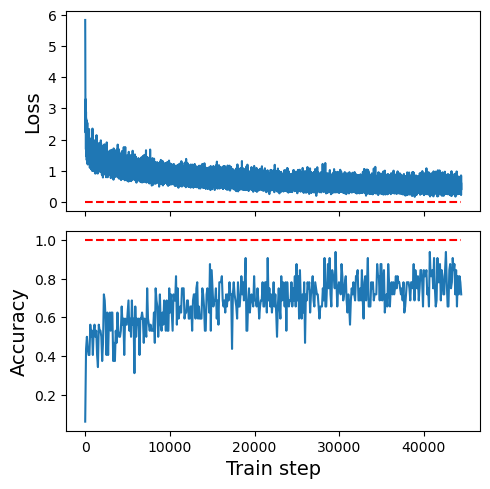

In [59]:
fig, axs = plt.subplots(2, sharex=True, figsize=(5, 5))
axs[0].plot(train_metrics['loss_history'])
axs[0].hlines(y=0, xmin=0, xmax=len(train_metrics['loss_history']), color='red', linestyle='--')
axs[0].set_ylabel('Loss', fontsize=14)
axs[1].plot(np.linspace(0, len(train_metrics['loss_history']), len(train_metrics['test_acc_history'])), train_metrics['test_acc_history'])
axs[1].hlines(y=1, xmin=0, xmax=len(train_metrics['loss_history']), color='red', linestyle='--')
axs[1].set_xlabel('Train step', fontsize=14)
axs[1].set_ylabel('Accuracy', fontsize=14)
axs[1].set_xlabel('Train step', fontsize=14)
fig.tight_layout()
fig.savefig(fig_outdir + 'train_history.png')

# Evaluate

In [60]:
dataset._df

,expnum,ra,dec,exptime,filter,propid,program,teff,fwhm,datetime,az,zd,ha,airmass,qc_fwhm,qc_cloud,qc_sky,qc_teff,timestamp,night
0,229250,301.199036,-50.938332,90,g,2012B-0001,survey,0.41,1.15,2013-08-31 23:55:07,139.550003,32.209999,-33.208458,1.18,1.15,0.42,1.26,0.41,1377993307,2013-08-31
1,229251,300.851105,-52.967278,90,g,2012B-0001,survey,0.60,1.18,2013-08-31 23:57:08,143.320007,32.759998,-32.380917,1.19,1.18,0.15,1.23,0.60,1377993428,2013-08-31
2,229252,300.460083,-54.996220,90,g,2012B-0001,survey,0.62,1.17,2013-08-31 23:59:08,146.949997,33.419998,-31.494499,1.20,1.17,-0.07,1.22,0.62,1377993548,2013-08-31
3,229253,300.016754,-57.024887,90,g,2012B-0001,survey,0.52,1.29,2013-09-01 00:01:11,150.449997,34.209999,-30.536041,1.21,1.29,-0.21,1.20,0.52,1377993671,2013-08-31
4,229254,302.722076,-58.040192,90,g,2012B-0001,survey,0.44,1.40,2013-09-01 00:03:13,150.589996,35.759998,-32.738377,1.23,1.40,0.04,1.20,0.44,1377993793,2013-08-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
439,230147,346.580597,-51.123997,90,i,2012B-0001,survey,0.96,1.00,2013-09-03 06:06:16,205.660004,24.170000,16.417084,1.10,1.00,-0.03,6.62,0.96,1378188376,2013-09-02
440,230148,352.174561,-53.153000,90,g,2012B-0001,survey,0.66,1.17,2013-09-03 06:08:36,196.779999,24.370001,11.475708,1.10,1.17,-0.07,1.14,0.66,1378188516,2013-09-02
441,230149,352.174530,-53.153027,90,r,2012B-0001,survey,0.69,1.11,2013-09-03 06:10:34,197.330002,24.469999,11.893500,1.10,1.11,-0.07,2.76,0.69,1378188634,2013-09-02
442,230194,9.097217,-40.979858,45,Y,2012B-0001,survey,0.35,1.40,2013-09-03 09:57:04,240.869995,42.860001,51.866333,1.36,1.40,0.07,15.51,0.35,1378202224,2013-09-02


In [61]:
import random

In [62]:
eval_actions = []
success_sequence = []
azel_sequence = [(az, el) for az, el in zip (dataset.states[:, 0], dataset.states[:, 1])]

with torch.no_grad():
    for i, state in enumerate(dataset.states):
        agent.algorithm.policy_net.to('cpu')
        q_vals = agent.algorithm.policy_net(state).unsqueeze(0)
        action = torch.argmax(q_vals, dim=1).item()
        eval_actions.append(action)
        
        candidates_in_bin = np.array(dataset.id2azel[action])
        success_sequence.append(azel_sequence[i] in candidates_in_bin)
        dataset.actions

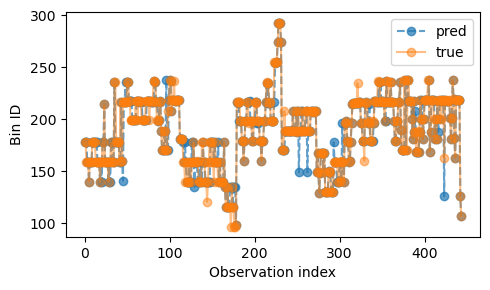

In [63]:
target_sequence = dataset.actions.detach().numpy()
eval_sequence = eval_actions

fig, axs = plt.subplots(1, figsize=(5,3))
axs.plot(eval_sequence, marker='o', linestyle='dashed', label='pred', alpha=.7)
axs.plot(target_sequence, marker='o', label='true', alpha=.5)
axs.legend()
axs.set_xlabel('Observation index')
axs.set_ylabel('Bin ID')

# axs[1].plot(eval_sequence - target_sequence, marker='o')
# axs[1].legend()
# axs[1].set_xlabel('obs index')
# axs[1].set_ylabel('pred - true')

fig.tight_layout()
fig.savefig(fig_outdir + 'learned_sequence.png')